![Intro](assets/intro.jpg)

# <span style="color:#ca9928">Introduction</span>

Pour cette mission 4, nous chercherons à expliquer le revenu des individus en fonction de plusieurs variables explicatives : le **pays de l'individu**, l'**indice de Gini** de ce pays, la **classe de revenus des parents**, etc.

Il s'agit donc d'**étudier l'impact d'une variable qualitative sur une variable quantitative**. Pour cela, nous allons devoir réaliser plusieurs ANOVA *(Analyse de variance)*.

Par exemple, la première question à se poser est :
>*Le pays a t'il un impact sur le revenu moyen de chaque classe ?*

Le modèle considéré ici s'écrit sous la forme suivante : $y_{i,j} = \mu + \alpha_i + \varepsilon_{i,j}$

pour $i \in \{1,...,116\}$ et $j \in \{1,...,n_i\}$

Dans ce modèle :
- $y_{ij}$ est le revenu $j$ avec la classe de revenu $i$ ;
- $\mu$ est le revenu moyen du pays;
- $\alpha_i$ ne dépend que de la classe de revenu.

On suppose ici que les classes de revenus sont homogènes et indépendantes, et que le revenu moyen des classes $i$ suit une loi normale de moyenne $\mu + \alpha_i$ et de variance $\sigma^2$ *(variance identique pour toutes les classes de revenu)*.

# <font color="#ca9928">Sommaire</font>

1. [ANOVA sur les données en n’incluant comme variable explicative que le pays de l’individu](#anova1)   
2. [Régression linéaire sur les données en n’incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu](#anova2)    
    1. [Pourcentage de variance expliquée par ce modèle](#tab_anova2)
    2. [Avec les données logaritmes](#anova2_ln)    
3. [Amélioration du dernier modèle avec la classe de revenus des parents](#anova3)
    1. [Pourcentage de variance expliquée par ce modèle](#tab_anova3)
    2. [Calcul des leviers](#leviers)
    3. [Les résidus studentisés](#student)    
    4. [Distances de Cook](#cook)   
    5. [Vérification de la colinéarité des variables](#colin)     
    6. [Test de l’homoscédasticité](#homosc)     
    7. [Test de la normalité des résidus](#resnorm)    
4. [Réponse à la dernière question sur l'indice de Gini](#gini_quest)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import scipy.stats as stats

plt.style.use('seaborn-whitegrid')

In [2]:
#import des données :
dataset = pd.read_csv("datas/df_wid500_cd.csv", sep=",", decimal=".", header=0)
dataset.head()

,country_code,c_i_child,G_j,income,gdpppp,m_j,p_j,c_i_parents
0,ALB,1,30.0,728.89795,7297.0,2994.829902,0.82,1.0
1,ALB,1,30.0,728.89795,7297.0,2994.829902,0.82,1.0
2,ALB,1,30.0,728.89795,7297.0,2994.829902,0.82,1.0
3,ALB,1,30.0,728.89795,7297.0,2994.829902,0.82,1.0
4,ALB,1,30.0,728.89795,7297.0,2994.829902,0.82,1.0


In [3]:
dataset.shape

(5800000, 8)

# <span style="color:#ca9928" id="anova1">ANOVA sur les données en n’incluant comme variable explicative que le pays de l’individu</span>

Nous allons réaliser cette ANOVA avec la librairie Statsmodels et la méthode des moindres carrés pour la régression linéaire. Les régressions seront réalisées à la fois avec les données de revenus et de classes brutes mais également avec leurs logarithmes.

Regardons dans un premier temps les boxplots de l'income sur les 10 pays sélectionnés en mission 2.

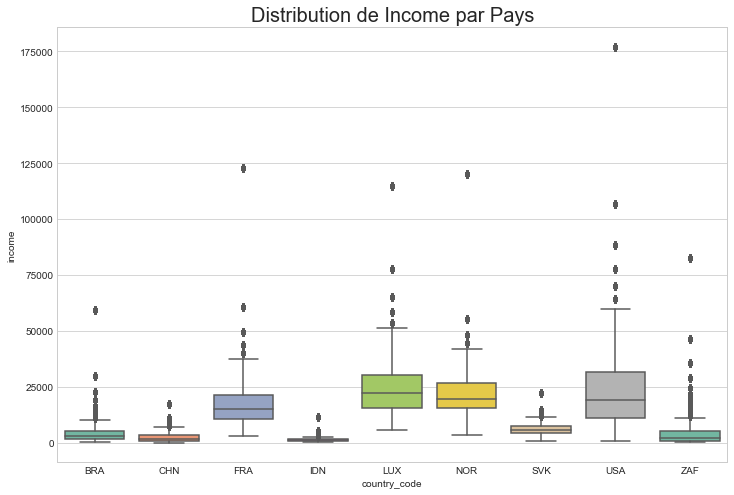

In [3]:
liste_pays_finale = ["BRA","IDN","LUX","NOR","SVK","ZAF","CHN","USA","FRA"]
fig = plt.figure(figsize=(12,8),constrained_layout=False)
ax = sns.boxplot(x="country_code", y="income", data=dataset[dataset["country_code"].isin(liste_pays_finale)], palette="Set2")
ax.set_title("Distribution de Income par Pays",fontsize=20)
plt.show()

On constate ici que les données analysées ne semblent pas être de variance égales.

In [5]:
model = ols('income ~ country_code', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 4.971e+04
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:24:14   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799884   BIC:                         1.186e+08
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2994.8299    

On remarque donc qu'il existe, selon le **test de Fischer**, un impact statistiquement significatif du pays sur le revenu moyen du pays $F = 4.97*10^{4}$ et $Pvalue = 0$. Le $R^2$ *(la part de variance expliquée par le modèle de régression)* est ici de 0.496

In [32]:
#Ajout des colonnes de log
dataset["ln_income"] = np.log(dataset["income"])
dataset["ln_c_i_parents"] = np.log(dataset["c_i_parents"])
dataset["ln_c_i_child"] = np.log(dataset["c_i_child"])
dataset["ln_m_j"] = np.log(dataset["m_j"])

In [5]:
dataset.sample(10)

,country_code,c_i_child,G_j,income,gdpppp,m_j,p_j,c_i_parents,ln_income,ln_c_i_parents,ln_c_i_child
5641424,VNM,83,35.80,1958.56430,2578.0,1377.773966,0.48,92.0,7.579967,4.521789,4.418841
2208558,IDN,18,36.70,617.11774,3689.0,1334.618297,0.50,8.0,6.425060,2.079442,2.890372
1675910,FJI,52,40.40,1482.86770,4300332.0,2098.730882,0.50,83.0,7.301733,4.418841,3.951244
4623126,RUS,47,41.60,4789.84960,14766.0,7156.770709,0.33,30.0,8.474254,3.401197,3.850148
1439824,ECU,80,49.70,4349.19800,7560.0,3383.741001,1.03,82.0,8.377747,4.406719,4.382027
5201294,TUR,3,39.00,825.75214,11904.0,6050.465331,0.40,33.0,6.716295,3.496508,1.098612
2745822,KAZ,92,28.50,3828.22100,10469.0,2239.149800,0.24,74.0,8.250155,4.304065,4.521789
4769301,SRB,39,27.52,3727.29960,10234.0,4879.750852,0.40,57.0,8.223439,4.043051,3.663562
5439135,UKR,79,26.60,4252.23730,6721.0,3349.388306,0.40,42.0,8.355201,3.737670,4.369448
3895787,NER,92,37.30,1215.81580,631.0,650.129353,0.66,83.0,7.103171,4.418841,4.521789


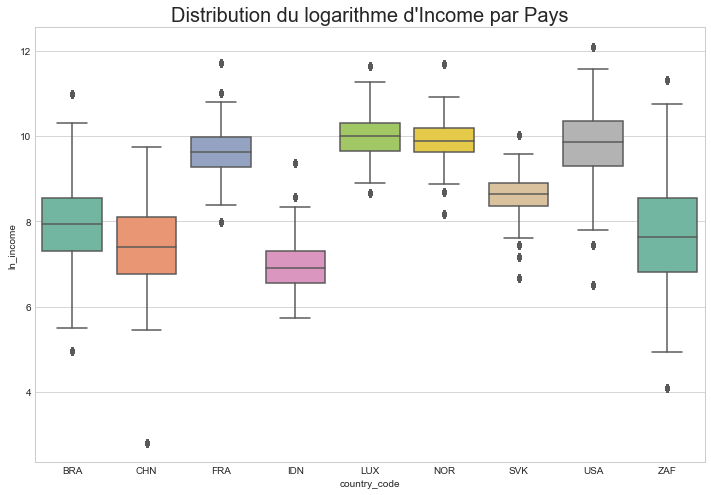

In [6]:
fig = plt.figure(figsize=(12,8),constrained_layout=False)
ax = sns.boxplot(x="country_code", y="ln_income", data=dataset[dataset["country_code"].isin(liste_pays_finale)], palette="Set2")
ax.set_title("Distribution du logarithme d'Income par Pays",fontsize=20)
plt.show()

En passant l'income à une échelle logarithmique, les variances semblent déjà être plus égalitaires. **Ce modèle sera donc probablement meilleur**. Vérifions :

In [9]:
model_ln = ols('ln_income ~ country_code', data=dataset).fit()

In [10]:
print(model_ln.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 1.358e+05
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:36:49   Log-Likelihood:            -6.3135e+06
No. Observations:             5800000   AIC:                         1.263e+07
Df Residuals:                 5799884   BIC:                         1.263e+07
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.8517    

Ce modèle basé sur le logarithme de l'Income est donc meilleur que le premier. Le $R^2$ est ici de 0.729 et **les critères basés sur l'information de Kullback (AIC / BIC) sont également plus petits**.

# <span style="color:#ca9928" id="anova2">Régression linéaire sur les données en n’incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu</span>

In [11]:
model_gini = ols('income ~ G_j*m_j', data=dataset).fit()
print(model_gini.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 1.906e+06
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:37:27   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799996   BIC:                         1.186e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.347e-09     20.482   3.59e-10      1.0

### <span style="color:#1c587c" id="tab_anova2">Pourcentage de variance expliquée par ce modèle</span>

L'équation d'analyse de variance pour ce modèle est la suivante : **$SCT = SCE + SCR$**    
Pour obtenir ces indicateurs, nous allons afficher la table d'analyse de variances avec Statsmodels, puis calculer les $\frac{SCE}{SCT}$ *(qui correspondent également au R²)* :

In [12]:
anova_table_gini = sm.stats.anova_lm(model_gini, typ=2)
anova_table_gini["eta_sq"] = anova_table_gini[:-1]['sum_sq']/sum(anova_table_gini['sum_sq'])
anova_table_gini

,sum_sq,df,F,PR(>F),eta_sq
G_j,1.142166e-10,1.0,2.559432e-18,1.0,2.349000e-25
m_j,2.274058e+14,1.0,5.095838e+06,0.0,4.676868e-01
G_j:m_j,1.080157e-10,1.0,2.420477e-18,1.0,2.221470e-25
Residual,2.588293e+14,5799996.0,NaN,NaN,NaN


Le R² de ce modèle est donc de 0.496, ce qui nous donne un **pourcentage de variance expliquée pour le modèle de 49.6 %**. Ce qui est cohérent avec me R² obtenu avec la variable Country_code *(En effet, l'indice de Gini combiné au revenu moyen du pays représentent bien le pays en lui même)*

### <span style="color:#1c587c" id="anova2_ln">Avec les données logaritmes</span>

In [66]:
model_gini_ln = ols('ln_income ~ G_j*ln_m_j', data=dataset).fit()
print(model_gini_ln.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                 5.180e+06
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:59:59   Log-Likelihood:            -6.3245e+06
No. Observations:             5800000   AIC:                         1.265e+07
Df Residuals:                 5799996   BIC:                         1.265e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0291      0.012      2.368      0.0

In [67]:
anova_table_gini_ln = sm.stats.anova_lm(model_gini_ln, typ=2)
anova_table_gini_ln["eta_sq"] = anova_table_gini_ln[:-1]['sum_sq']/sum(anova_table_gini_ln['sum_sq'])
anova_table_gini_ln

,sum_sq,df,F,PR(>F),eta_sq
G_j,1.077795e+05,1.0,2.079058e+05,0.000000e+00,0.010735
ln_m_j,6.925125e+06,1.0,1.335851e+07,0.000000e+00,0.689726
G_j:ln_m_j,7.523316e+02,1.0,1.451241e+03,1.687277e-317,0.000075
Residual,3.006750e+06,5799996.0,NaN,NaN,NaN


In [68]:
#Autre méthode de calcul de la variance expliquée du modèle
var_exp_model = round((model_gini_ln.ess / model_gini_ln.centered_tss)*100,2)
var_exp_model

72.82

Le R² de ce modèle est donc de 0.591, ce qui nous donne un **pourcentage de variance expliquée pour le modèle à échelle logarithmique de 72.82 %**.

#### <span style="color:#1c587c" id="anova2_ln">Décomposition de la variance :</span>

In [69]:
var_exp_pays = round(sum(anova_table_gini_ln[0:3]["eta_sq"])*100,2)
print("Le pourcentage de la variance expliquée par le pays de naissance est donc de :",var_exp_pays,"%")

Le pourcentage de la variance expliquée par le pays de naissance est donc de : 70.05 %


In [70]:
var_exp_autres = round(var_exp_model - var_exp_pays,2)
print("Le pourcentage de la variance expliquée par les autres facteurs non considérés est donc de :",var_exp_autres,"%")

Le pourcentage de la variance expliquée par les autres facteurs non considérés est donc de : 2.77 %


In [71]:
#Variance totale SCT
model_gini_ln.centered_tss

11062515.264065742

In [72]:
#Variance expliquée SCE
model_gini_ln.ess

8055765.204308175

In [73]:
#Variance résiduelle SCR
model_gini_ln.ssr

3006750.059757568

# <span style="color:#ca9928" id="anova3">Amélioration du dernier modèle avec la classe de revenus des parents</span>

In [7]:
model_global = ols('income ~ c_i_parents*G_j*m_j', data=dataset).fit()
print(model_global.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                 9.862e+05
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:44:58   Log-Likelihood:            -5.9026e+07
No. Observations:             5800000   AIC:                         1.181e+08
Df Residuals:                 5799992   BIC:                         1.181e+08
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -623.3582    

In [74]:
model_global_ln = ols('ln_income ~ ln_c_i_parents*G_j*ln_m_j', data=dataset).fit()
print(model_global_ln.summary()) 

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 3.005e+06
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:01:56   Log-Likelihood:            -5.6597e+06
No. Observations:             5800000   AIC:                         1.132e+07
Df Residuals:                 5799992   BIC:                         1.132e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [75]:
anova_table_global_ln = sm.stats.anova_lm(model_global_ln, typ=2)
anova_table_global_ln["eta_sq"] = anova_table_global_ln[:-1]['sum_sq']/sum(anova_table_global_ln['sum_sq'])
anova_table_global_ln

,sum_sq,df,F,PR(>F),eta_sq
ln_c_i_parents,5.150196e+05,1.0,1.249449e+06,0.000000e+00,0.051347
G_j,1.077795e+05,1.0,2.614754e+05,0.000000e+00,0.010746
ln_c_i_parents:G_j,8.816544e+04,1.0,2.138913e+05,0.000000e+00,0.008790
ln_m_j,6.925125e+06,1.0,1.680050e+07,0.000000e+00,0.690433
ln_c_i_parents:ln_m_j,4.566935e+02,1.0,1.107948e+03,6.521655e-243,0.000046
G_j:ln_m_j,7.523316e+02,1.0,1.825173e+03,0.000000e+00,0.000075
ln_c_i_parents:G_j:ln_m_j,2.072542e+03,1.0,5.028033e+03,0.000000e+00,0.000207
Residual,2.390742e+06,5799992.0,NaN,NaN,NaN


Cette fois encore, le modèle avec les échelles logaritmiques est meilleur sur tous les indicateurs. Nous allons donc considérer ce dernier modèle ln.

### <span style="color:#1c587c" id="tab_anova3">Pourcentage de variance expliquée par ce modèle</span>

Sur ce dernier modèle, **le pourcentage de variance expliqué est de 78.4 %**, ce qui en fait, à priori, le meilleur modèle pour cette analyse.

In [76]:
var_exp_pays_ci_parents = round(sum(anova_table_global_ln[0:-1]["eta_sq"])*100,2)
print("Le pourcentage de la variance expliquée par le pays de naissance et la classe des parents est donc de :",var_exp_pays_ci_parents,"%")

Le pourcentage de la variance expliquée par le pays de naissance et la classe des parents est donc de : 76.16 %


In [77]:
var_exp_model_2 = round((model_global_ln.ess / model_global_ln.centered_tss)*100,2)
var_exp_autres_2 = round(var_exp_model_2 - var_exp_pays_ci_parents,2)
print("Le pourcentage de la variance expliquée par les autres facteurs non considérés est donc de :",var_exp_autres_2,"%")

Le pourcentage de la variance expliquée par les autres facteurs non considérés est donc de : 2.23 %


Nous allons donc réaliser quelques tests supplémentaires sur ce dernier modèle :
### <span style="color:#1c587c" id="leviers">Calcul des leviers</span>

In [78]:
#Les test seront réalisés à un niveau de 5%
alpha = 0.05
#Récupérons le nombre d'individus de l'échantillon (n), le nombre de variables (p).
n = dataset.shape[0]
p = 4

In [79]:
#influences
influences = model_global_ln.get_influence()

Le seuil des leviers est défini par la formule $Seuil = 2 * \frac{p}{n}$

In [80]:
dataset['levier'] = influences.hat_matrix_diag
seuil_levier = 2*p/n

### <span style="color:#1c587c" id="student">les résidus studentisés</span>

Les résidus sont dit studentisés lorsqu’ils sont divisés par leur écart-type empirique. Le seuil pour les résidus studentisés est une loi de Student à $n-p-1$ degrés de liberté et pour les grands échantillons, ils doivent rester compris entre -2 et 2 :

In [81]:
from scipy.stats import t, shapiro
dataset['rstudent'] = influences.resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

### <span style="color:#1c587c" id="cook">Distances de Cook</span>
Le seuil de la distance de Cook est de $n-p$.

In [82]:
smf = influences.cooks_distance
dataset['dcooks'] = smf[0]
seuil_dcook = 4/(n-p)

In [83]:
df_atypiques = dataset[(dataset["levier"]>seuil_levier) | (np.abs(dataset["rstudent"])>seuil_rstudent) | (dataset["dcooks"]>seuil_dcook)]
print("Nombre d'individus atypiques :", len(df_atypiques))

Nombre d'individus atypiques : 1675862


In [84]:
df_atypiques.groupby(by=["country_code","c_i_child","c_i_parents"]).mean()

G_j       income  gdpppp          m_j  \
country_code c_i_child c_i_parents                                           
ALB          1         1.0          30.0    728.89795  7297.0  2994.829902   
                       2.0          30.0    728.89795  7297.0  2994.829902   
                       3.0          30.0    728.89795  7297.0  2994.829902   
                       4.0          30.0    728.89795  7297.0  2994.829902   
                       5.0          30.0    728.89795  7297.0  2994.829902   
...                                  ...          ...     ...          ...   
ZAF          100       96.0         63.0  82408.55000  9602.0  5617.904880   
                       97.0         63.0  82408.55000  9602.0  5617.904880   
                       98.0         63.0  82408.55000  9602.0  5617.904880   
                       99.0         63.0  82408.55000  9602.0  5617.904880   
                       100.0        63.0  82408.55000  9602.0  5617.904880   

                                     p_j  ln_income  ln_c_i_parents  \
country_code c_i_child c_i_parents                                    
ALB          1         1.0          0.82   6.591534        0.000000   
                       2.0          0.82   6.591534        0.693147   
                       3.0          0.82   6.591534        1.098612   
                       4.0          0.82   6.591534        1.386294   
                       5.0          0.82   6.591534        1.609438   
...                                  ...        ...             ...   
ZAF          100       96.0         0.68  11.319444        4.564348   
                       97.0         0.68  11.319444        4.574711   
                       98.0         0.68  11.319444        4.584967   
                       99.0         0.68  11.319444        4.595120   
                       100.0        0.68  11.319444        4.605170   

                                    ln_c_i_child    levier  rstudent  \
country_code c_i_child c_i_parents                                     
ALB          1         1.0               0.00000  0.000006 -0.847865   
                       2.0               0.00000  0.000004 -1.065228   
                       3.0               0.00000  0.000003 -1.192377   
                       4.0               0.00000  0.000003 -1.282591   
                       5.0               0.00000  0.000002 -1.352567   
...                                          ...       ...       ...   
ZAF          100       96.0              4.60517  0.000006  4.188060   
                       97.0              4.60517  0.000006  4.175389   
                       98.0              4.60517  0.000006  4.162848   
                       99.0              4.60517  0.000006  4.150435   
                       100.0             4.60517  0.000006  4.138146   

                                          dcooks    ln_m_j  
country_code c_i_child c_i_parents                          
ALB          1         1.0          5.788908e-07  8.004643  
                       2.0          6.177568e-07  8.004643  
                       3.0          5.932992e-07  8.004643  
                       4.0          5.568577e-07  8.004643  
                       5.0          5.193949e-07  8.004643  
...                                          ...       ...  
ZAF          100       96.0         1.237945e-05  8.633714  
                       97.0         1.244351e-05  8.633714  
                       98.0         1.250700e-05  8.633714  
                       99.0         1.256989e-05  8.633714  
                       100.0        1.263220e-05  8.633714  

[317088 rows x 12 columns]

Naturellement, **nous ne pouvons pas supprimer autant de valeurs atypiques de notre jeu de données**. Ici la solution pour un algorithme plus performant serait peut-être d'inclure la région de notre pays pour les regrouper en clusters cohérents, ou d'inclure d'autres facteurs sociétaux.

Pour afficher les graphiques de leviers, résidus studentisés et distance de Cook, nous ne pouvons pas le faire sur les 5 800 000 individus. **Nous allons donc créer un DataFrame groupé en calculant les moyennes des indicateurs par pays**. Nous pourrons ainsi repérer les pays atypiques.

In [87]:
gp_dataset = dataset.groupby(by=["country_code"]).mean().reset_index()

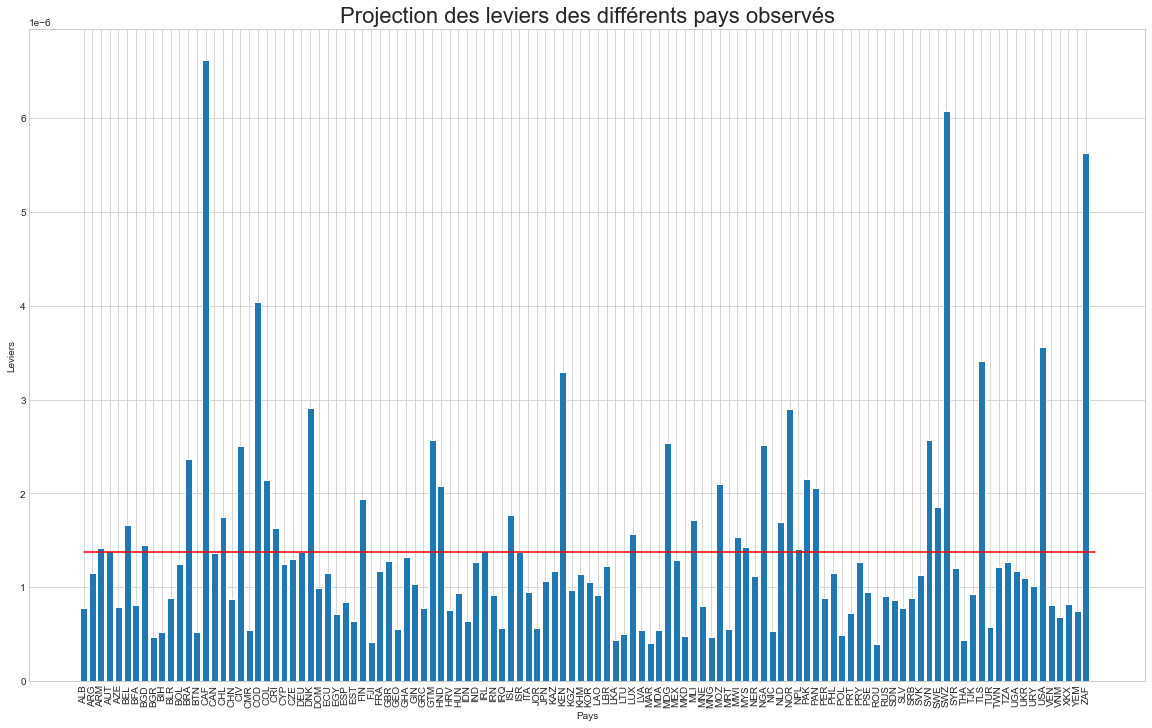

In [89]:
#Barplot des leviers
plt.figure(figsize=(20,12))
plt.bar(gp_dataset["country_code"], gp_dataset['levier'])
plt.xticks(np.arange(0, 116, step=1), rotation='vertical')
plt.xlabel('Pays')
plt.ylabel('Leviers')
plt.title("Projection des leviers des différents pays observés", fontsize=22)
plt.plot([0, 116], [seuil_levier, seuil_levier], color='r')
plt.show()

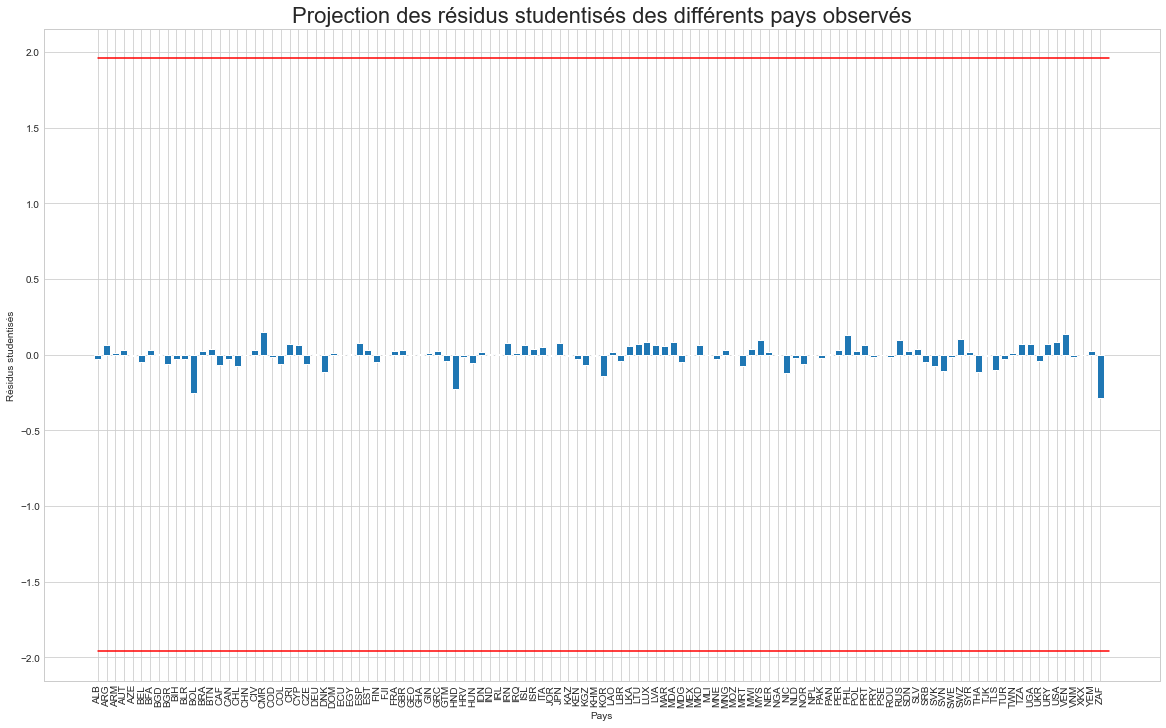

In [90]:
#Barplot des résidus studentisés
plt.figure(figsize=(20,12))
plt.bar(gp_dataset["country_code"], gp_dataset['rstudent'])
plt.xticks(np.arange(0, 116, step=1), rotation='vertical')
plt.xlabel('Pays')
plt.ylabel('Résidus studentisés')
plt.title("Projection des résidus studentisés des différents pays observés", fontsize=22)
plt.plot([0, 116], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 116], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

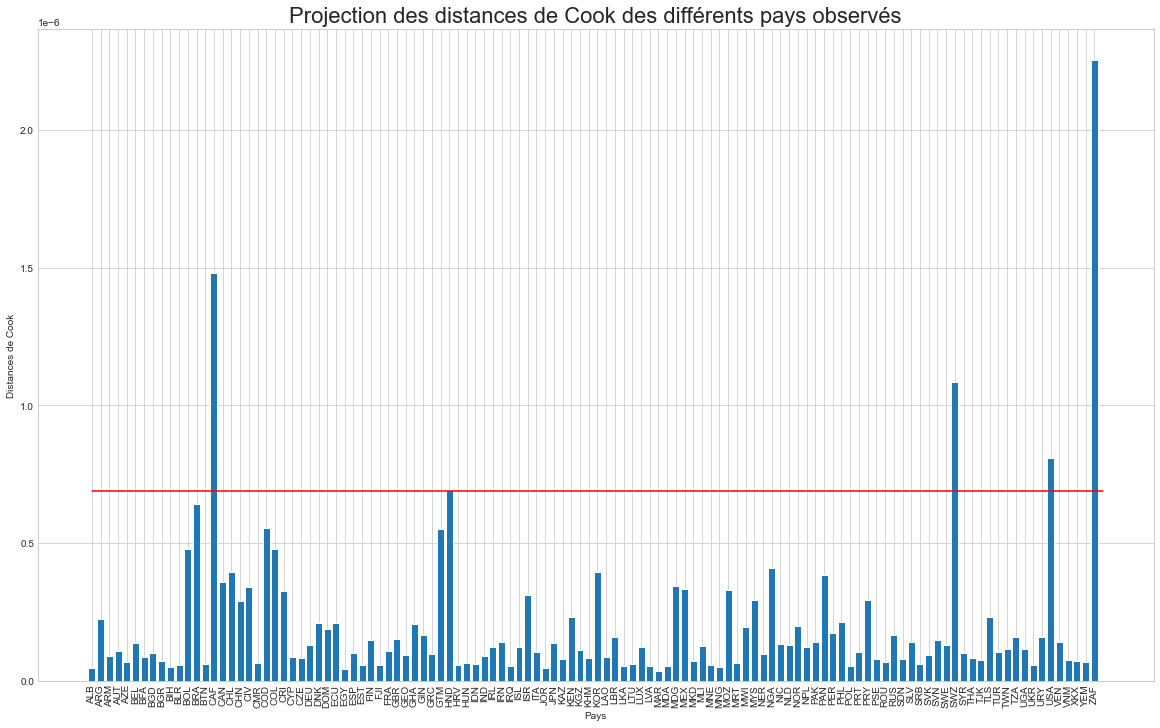

In [91]:
#Barplot de la distance de Cook
plt.figure(figsize=(20,12))
plt.bar(gp_dataset["country_code"], gp_dataset['dcooks'])
plt.xticks(np.arange(0, 116, step=1), rotation='vertical')
plt.xlabel('Pays')
plt.ylabel('Distances de Cook')
plt.title("Projection des distances de Cook des différents pays observés", fontsize=22)
plt.plot([0, 116], [seuil_dcook, seuil_dcook], color='r')
plt.show()

### <span style="color:#1c587c" id="colin">Vérification de la colinéarité des variables</span>

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = model_global_ln.model.exog
vif = [variance_inflation_factor(variables, exog_idx = i) for i in np.arange(1,variables.shape[1])]

In [93]:
df_vif = pd.DataFrame(index = anova_table_global_ln.index[0:-1], columns = ["VIF"])
df_vif["VIF"] = vif
df_vif

,VIF
ln_c_i_parents,1690.053870
G_j,1343.794642
ln_c_i_parents:G_j,3074.571118
ln_m_j,528.756479
ln_c_i_parents:ln_m_j,2127.973892
G_j:ln_m_j,1417.664189
ln_c_i_parents:G_j:ln_m_j,3075.453148


La documentation de Statsmodels nous indique que si le VIF est supérieur à 5, alors **la variable explicative donnée par exog_idx est hautement colinéaire avec les autres variables explicatives**. Cela pourrait apporter des erreurs importantes à notre modèle.

### <span style="color:#1c587c" id="homosc">Test de l’homoscédasticité</span>
L’homoscédasticité représente la constance de la variance des résidus :

In [94]:
_, pval, __, f_pval = sms.het_breuschpagan(model_global_ln.resid, variables)
print('p-value test Breusch Pagan:', pval)

p-value test Breusch Pagan: 0.0


La p-value est ici inférieure à  5 %, **on rejette donc l'hypothèse selon laquelle les variances sont constantes** *(l'hypothèse d’homoscédasticité)*.

### <span style="color:#1c587c" id="resnorm">Test de la normalité des résidus</span>
Nous allons dans un premier temps réaliser un test de Shapiro-Wilk :

In [95]:
shapiro(model_global_ln.resid)

C:\Users\OpenClassrooms\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9815455079078674, pvalue=0.0)

On remarque ici que **l'hypothèse de normalité est rejetée au niveau de test 5%**, mais nous avons un warning dû au grand nombre d'individu. Traçons donc la distribution des résidus avec Seaborn pour vérifier :

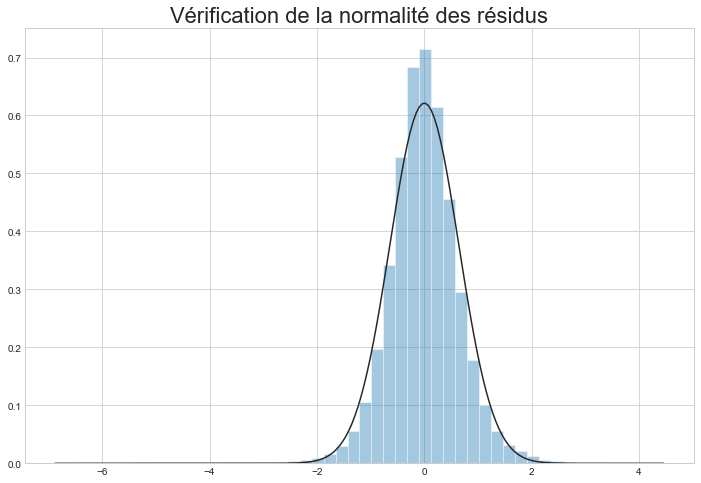

In [96]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(model_global_ln.resid, fit=stats.norm, kde=False)
ax.set_title("Vérification de la normalité des résidus", fontsize=22)
plt.show()

Sur ce graphique, on remarque donc que la **distribution des résidus suit bien une distribution normale**. Affichons le QQPlot pour terminer cette analyse.

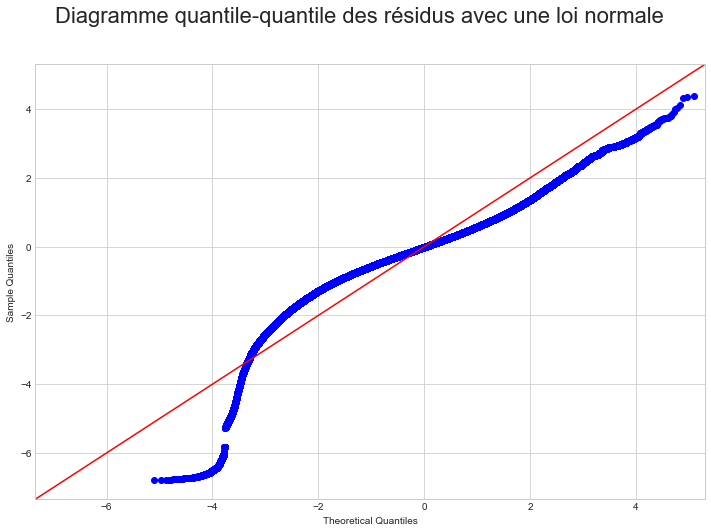

In [97]:
fig = sm.qqplot(model_global_ln.resid, line="45")
fig.set_size_inches(12, 8)
fig.suptitle("Diagramme quantile-quantile des résidus avec une loi normale", fontsize=22)
plt.show()

# <span style="color:#ca9928" id="gini_quest">Réponse à la dernière question sur l'indice de Gini</span>

Voici la question posée : **En observant le coefficient de régression associé à l’indice de Gini, peut-on affirmer que le fait de vivre dans un pays plus inégalitaire favorise plus de personnes qu’il n’en défavorise ?**

Comme nous l'avons déjà vu, plus l'indice de Gini est élevé, plus la répartition du pays est inégalitaire. De ce fait, une petite proportion de la population détient la plus grosse part des richesses. Les écarts dans les salaires sont très élevés avec des revenus par individus faible. 

Le coeffiscient de regression de l'indice de Gini, certes faible mais positif, ne nous permet pas d'affirmer que le fait de vivre dans un pays plus inégalitaire favorise plus de personnes qu'il n'en défavorise.